Simulates a multivariable geometric brownian motion with 3 variables, and performs inference on
the drift parameters, before outputting metrics for the posterior distributions.

First, import the relevant packages

In [9]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import bayesflow as bf
import os
import jax

Next, we define our global random number generator, as well as the DRIFT_SCALE parameter, which is used to control the general direction of each path (in the context of a stock, it can be thought of as the expected return)

In [10]:
RNG = np.random.default_rng(int(os.times()[4]))
DRIFT_SCALE = 0.4

We then define a function to get a random draw from our prior distribution of the drift parameters, which we model here as a uniform random variable from -DRIFT_SCALE to DRIFT_SCALE

In [11]:
def prior():
    # Generates a random draw from the prior

    b1 = RNG.uniform(-DRIFT_SCALE, DRIFT_SCALE)
    b2 = RNG.uniform(-DRIFT_SCALE, DRIFT_SCALE)
    b3 = RNG.uniform(-DRIFT_SCALE, DRIFT_SCALE)

    return {"b1":b1, "b2":b2, "b3":b3}

We then define our simulator, which generates a simulation over a given time length in the specified number of time steps using the formula for a multivariate geometric brownian motion. This is then outputted as a dictionary to be passed on in our workflow

In [12]:
def GBM_sim(b1, b2, b3, x0 = np.array([100, 100, 100]), time = 100/365, time_step = 1/365):
    sigma = np.array([[0.5, 0.1, 0.0],
                      [0.0, 0.1, 0.3],
                      [0.0, 0.0, 0.2]])

    x = x0

    motion = [x0]

    for _ in range(0, int(time/time_step) - 1):
        drift_coef = np.array([b1, b2, b3])
        correction = 0.5*np.sum([sigma[:, j]**2 for j in range(0, 3)], axis=0)
        drift = drift_coef - correction
        timescaled_drift = drift * time_step
        random_shocks = sigma @ RNG.normal(scale=np.sqrt(time_step), size=3)
        dx = x * (timescaled_drift + random_shocks)
        x = x + dx
        motion.append(x)

    return dict(motion=np.asarray(motion))

Finally, in preparation for performing bayesian inference, we use a Gated Recurrent Unit (GRU) to process our time-series data into a format usable for our network

In [13]:
class GRU(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.gru = keras.layers.GRU(128, dropout=0.1)
        self.summary_stats = keras.layers.Dense(64)

    def call(self, time_series, **kwargs):
        summary = self.gru(time_series, training=kwargs.get("stage") == "training")
        summary = self.summary_stats(summary)
        return summary

Now, lets run bayesian inference on this simulator using a CouplingFlow inference network and plot our learned distributions. First, we define the components of our network: the simulator (the combination of our prior generation function and the simulator that generates data with those priors); the adapter (which formats the data to be input into our network); the summary network (transforms the summary variables into a usable format); and the inference network (to actually perform the amortized inference)

In [14]:
simulator = bf.simulators.make_simulator([prior, GBM_sim])

adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series("motion")
    .concatenate(["b1", "b2", "b3"], into="inference_variables")
    .rename("motion", "summary_variables")
    .log(["inference_variables", "summary_variables"], p1=True)
)

summary_net = bf.networks.TimeSeriesNetwork(dropout=0.1)

inference_net = bf.networks.CouplingFlow(transform="spline", depth=2, dropout=0.1)

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net,
    standardize=None
)

Then it's time to train our network, so we create training and validation datasets, which we train our network on, and plot the loss function.

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.6612 - val_loss: -0.2306
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: -0.0403 - val_loss: 0.0552
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: -0.1603 - val_loss: -0.3446
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: -0.2393 - val_loss: -0.3488
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: -0.2845 - val_loss: -0.4058
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: -0.4604 - val_loss: -0.7114
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: -0.7043 - val_loss: -0.5204
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: -0.8630 - val_loss: -0.9181
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: -0.9825 - val_loss: -1.1766
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: -1.0878 - val_loss: -1.3712
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: -1.1468 - val_loss: -1.3144
Epoch 12/1

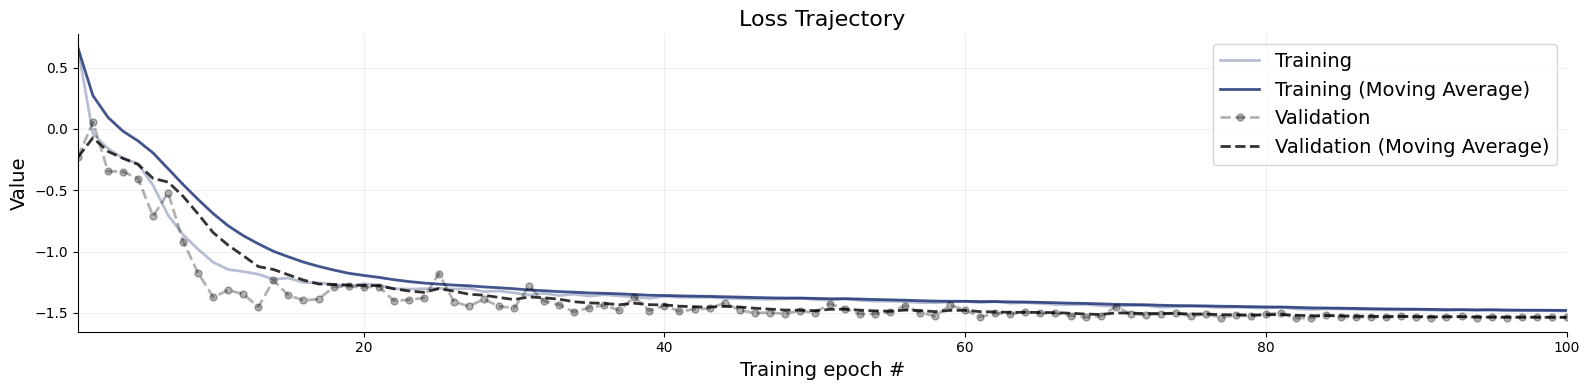

In [15]:
train = workflow.simulate(8000)
validation = workflow.simulate(300)

history = workflow.fit_offline(data=train,
                               epochs=100,
                               batch_size=32,
                               validation_data=validation)

f = bf.diagnostics.plots.loss(history)

plt.show()

Finally, lets test the inference network by sampling the posterior distribution for a given input simulated input and seeing what distributions we learned for our three drift parameters vs the ground truth

In [3]:
num_datasets = 300
num_samples = 1000

# Simulate 300 scenarios
print("Making simulations")
test_sims = workflow.simulate(num_datasets)

# Obtain num_samples posterior samples per scenario
print("Sampling")
samples = workflow.sample(conditions=test_sims, num_samples=num_samples)

print("Making plots")
f = bf.diagnostics.plots.recovery(samples, test_sims)

b1_truth = test_sims["b1"][0].item()
b2_truth = test_sims["b2"][0].item()
b3_truth = test_sims["b3"][0].item()
truths = np.asarray([b1_truth, b2_truth, b3_truth])

b1_samples = samples["b1"][0].flatten()
b2_samples = samples["b2"][0].flatten()
b3_samples = samples["b3"][0].flatten()
out_samples = np.asarray([b1_samples, b2_samples, b3_samples]).T

labels = ["b1", "b2", "b3"]

d = out_samples.shape[1]

plt.style.use('dark_background')
fig, axes = plt.subplots(d, d, figsize=(8, 8))

for i in range(d):
    for j in range(d):
        ax = axes[i, j]
        if i == j:
            ax.set_facecolor("white")  # set background blue
            ax.hist(out_samples[:, i], bins=40, histtype="step", color="lightblue")
            ax.axvline(truths[i], color="red")
            ax.set_xlabel(labels[i])
        elif i < j:
            ax.set_facecolor("midnightblue")  # set background blue
            h = ax.hist2d(out_samples[:, j], out_samples[:, i],
                          bins=50, cmap="viridis")
            ax.plot(truths[j], truths[i], "o", color="red")
        else:
            ax.axis("off")

plt.tight_layout()
plt.show()

Making simulations


NameError: name 'workflow' is not defined